In [7]:
import torch
from PIL import Image
from torchvision.models import resnet18, resnet50
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision
from torch.optim import lr_scheduler, SGD
import torch.nn as nn
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import copy

from pathlib import Path
import logging
import time

In [8]:
%env TORCH_HOME=models
model = resnet50(pretrained=True)

env: TORCH_HOME=models


# Input for pretrained models
---

Images have to have shape (3xHxW), H and W are expected to be at least 224.

Images have to be loaded in to a range of [0, 1] and then normalized using the following.

### Load Data

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [10]:
transforming_data = {
    'train': transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize,
                    ]),
    'validation': transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                        ])
}

In [11]:
directory_data = Path('datasets', 'monkey_poses')

In [12]:
datasets_images = {x: datasets.ImageFolder((directory_data / x), transforming_data[x])
                        for x in ['train', 'validation']
                    }

In [13]:
loaders_data = {x: torch.utils.data.DataLoader(datasets_images[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                    for x in ['train', 'validation']
                }

In [14]:
sizes_datasets = {x: len(datasets_images[x]) for x in ['train', 'validation']}

class_names = datasets_images['train'].classes

class_names

['sitting', 'standing2legs', 'standing4legs', 'walking']

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize Data *optional*

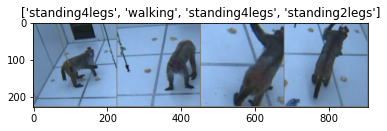

In [17]:
plt.ion()   # This is the interactive mode
def visualize_data(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
       plt.title(title)
    plt.pause(0.001)  ## Here we are pausing a bit so that plots are updated
inputs_data, classes = next(iter(loaders_data['train']))
## This is the code for getting a batch of training data
out = torchvision.utils.make_grid(inputs_data)
## Here we are making a grid from batch
visualize_data(out, title=[class_names[x] for x in classes])

### Train Model

In [18]:
def model_training(res_model, criterion, optimizer, scheduler, number_epochs=25):
    since = time.time()
    best_resmodel_wts = copy.deepcopy(res_model.state_dict())
    best_accuracy = 0.0
    for epochs in range(number_epochs):
        print('Epoch {}/{}'.format(epochs, number_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'validation']: ## Here each epoch is having a training and validation phase
            if phase == 'train':
               res_model.train()  ## Here we are setting our model to training mode
            else:
               res_model.eval()   ## Here we are setting our model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_data[phase]: ## Iterating over data.
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() ## here we are making the gradients to zero

                with torch.set_grad_enabled(phase == 'train'): ## forwarding and then tracking the history if only in train
                     outputs = res_model(inputs)
                     _, preds = torch.max(outputs, 1)
                     loss = criterion(outputs, labels)

                     if phase == 'train': # backward and then optimizing only if it is in training phase
                         loss.backward()
                         optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes_datasets[phase]
            epoch_acc = running_corrects.double() / sizes_datasets[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc: ## deep copy the model
                best_accuracy = epoch_acc
                best_resmodel_wts = copy.deepcopy(res_model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    res_model.load_state_dict(best_resmodel_wts)
    return res_model

### Visualize Predictions

In [20]:
def model_visualization(res_model, num_images=6):
    was_training = res_model.training
    res_model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders_data['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = res_model(inputs)
            _, preds = torch.max(outputs, 1)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            visualize_data(inputs.cpu().data[j])

            if images_so_far == num_images:
               res_model.train(mode=was_training)
               return
        res_model.train(mode=was_training)

### Finetune Convet

In [21]:
finetune_model = resnet50(pretrained=True)
num_ftrs = finetune_model.fc.in_features

finetune_model.fc = nn.Linear(num_ftrs, 2)

finetune_model = finetune_model.to(device)

criterion = nn.CrossEntropyLoss()

finetune_optim = SGD(finetune_model.parameters(), lr=0.001, momentum=0.9)

### Training and Evaluation

In [22]:
finetune_model = model_training(finetune_model, criterion, finetune_optim, lr_scheduler,
                       number_epochs=25)

Epoch 0/24
----------


IndexError: Target 2 is out of bounds.

### Visualize final result

In [ ]:
model_visualization(finetune_model)